## Analysis set-up

### Import required packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from numpy import median
import geopandas as gpd
#import contextily as cx
import plotly.express as px
import plotly.graph_objects as go
import string
import random
import numpy as np
import re
pd.set_option('display.max_rows', 50)

### Set file path

In [13]:
file_path = '/Users/franpontin/OneDrive - University of Leeds/CDRC/Projects/IGD/Analysis/product_data/'


### Define functions

#### Function to report classification progress 

In [3]:
def progress(df):
  #gives progress on EW calssificaiton
   print('N left to classify:',len(df.loc[df['Eatwell_Segment']=='Not Food',:]),
      '(Percentage classified =', 
      np.round(100-len(df.loc[df['Eatwell_Segment']=='Not Food',:])/len(df)*100,2), '%)')


#### Function to match product descritpiton/name to Eatwell categroy 

In [18]:
def match_to_EW(df, list_of_columns):
    df[list_of_columns] =df[list_of_columns].astype('string')
    n=len(list_of_columns)
    ewList =['EW_' + x for x in list(map(str, list(range(0, n))))]
    df[ewList]=np.nan
    for i in range(len(ew_cat_wordLists)):
        wordList = ew_cat_wordLists[i]
        print(i+1, 'categories matched of', len(ew_cat_wordLists)) 
        for word in wordList:
            for j in range(len(w_segList)):
            # find where there is a word to macth, 
            # and it has not yet been matched in another cat (order of cat names important)
            # match the word to the word list and assign EW cat to word
                        df.loc[(df[w_segList[j]].notnull())&
                        (~df[ewList[j]].notnull())&
                        (df[w_segList[j]].str.contains(word, case=False, )),#flags=re.IGNORECASE, regex=True
                        ewList[j]] = ew_cat[i]
    df['nunique_EW']=df[ewList].apply(pd.Series.nunique, axis=1)
    #example['EW_multi_cats'] =example[['EW_0','EW_1','EW_2','EW_3','EW_4','EW_5','EW_6','EW_7','EW_8','EW_9','EW_10','EW_11','EW_12']].fillna("").astype(str).fillna("").apply(lambda x: ' '.join(x), axis=1).fillna("")
    df['EW_multi_cats'] =df[ewList].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
    df['total_seg_matched']=df[ewList].count(axis=1)  
    mode_n =df[['EW_0','EW_1','EW_2','EW_3','EW_4','EW_5','EW_6']].mode(axis=1).shape[1]
    modeList =['mode_' + x for x in list(map(str, list(range(1, mode_n+1))))]
    df[modeList] =df[ewList].mode(axis=1)
    df['Eatwell_Segment'] = 'Not Food'

#### Function to assign Eatwell classification based on matching, including detail of logic behind the match

In [21]:
def assign_EW(df, conditions, confidence_val, confidence_scale, match_detail, ew_cat):
    print('N='+str(len(df.loc[conditions,:])))
    df.loc[conditions, 'class_confidence_calc']=confidence_val
    df.loc[conditions, 'class_confidence']= confidence_scale
    df.loc[conditions, 'match_detail']= match_detail
    df.loc[conditions&(df['Eatwell_Segment']=='Not Food'),'Eatwell_Segment'] = ew_cat
    print('Match conditions:',match_detail)
    progress(df)
    

### Read in test product data and additional list of fruit and veg

In [14]:
df = pd.read_csv(file_path+'product_data.csv')
veg_list =pd.read_csv(file_path+'veg_list.csv',index_col=0)

veg_list =list(veg_list['name'])

/opt/anaconda3/envs/geo_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (1,4,5,6,7,8,9,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,48,51,52,53,54,56,57,58,60,61,64,66,68,88,89,90,93,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Define products in each Eatwell category

In [16]:


ew_fnv = veg_list+['courgette','dudhi','mooli', 'gourd','melon','currants', 'sultanas','swede','veg',
                   'fruit','gherkin','pickle','olives']
ew_car = ['bread','cereal','flour','pasta','pastry','potato','rolls',r'\brice\b',
          'waffles','zwieback', 'muffin', 'teff', 'bagel', r'\bcorn\b', 'spaghetti',
          'whole wheat', 'crackers', 'noodles', 'wheat', 'couscous','cous cous', 'tortilla',
          'nann','taco','pitta','wrap','chapati','chappatti', 'chapatti','sourdough',r'\bpave\b','boule','bloomer','paratha',
          'bao','cassava','naan','porridge','museli', 'muesli','baguette','quinoa','ciabatta',r'\broti\b',
          'sourdough', 'baps', 'brioche','pennoni', 'loaf','fusilli','macaroni','focaccia'] # zwieback is carb or disc? doesn't matter for this tho

ew_ptn = ['beef','chicken','domestic eggs', 'lamb','fish','frankfurter',r'\bham\b',
          'liver loaf','meat','nut','pork','sausage','turkey', 'crustaceans',
          'bean', 'chickpea', 'veal','poultry', 'steak', 'neck', 'mince',
         'fillet', 'loin', 'ostrich', 'egg', 'mollusk', 'emu', 'goose', 'duck',
          'Goat', 'lentils', 'marrow', 'flesh', 'tofu','beancurd', 'prawn', 'hummus', 'houmous',
         'haddock','salmon',r'\bcod\b','capers','tuna','breast','lobster','thighs','drumstick',
          'prosciutto','wagyu','joint', 'quorn', 'bacon', 'brisket','burger','almonds', 
          r'\bnuts\b','pistachios','pecans','butter beans','rotisserie','mortadella','kala chana',
         'liver','pig in blanket','seafood'] # marrow very fatty

ew_oil = ['butter','margarine',r'\boil\b', 'lard','spreads','vegetable oil', 'sunfower oil']
ew_dai = ['milk','whole milk','butter milk','cream','cheese','curd','yogurt', 'yoghurt','shortening',
          r'\bmilk alternatives\b', r'\blactose free drinks\b', r'\boat & nut drinks\b','kefir','cheesy',
          'brie','mozzerella','mozzarella','cheesy single', 'cheddar', 'gloucester','leicester','soya','halloumi',
          'wensleydale','coconut milk','stilton', 'paneer','feta','Lactofree','fraiche']

ew_dis = ['candy','cake','sweetener','chocolate','choc','dessert','ice cream',
          'mustard','mayonnaise','salty snack','pudding powder','popcorn',
          'sweet spreads','syrup','sugar','jam','ketchup', 'fudge', 'cocoa',
          'snack products','sauce', 'cookie','pastries', 'pudding', 'pancake',
         'candies', 'wafer', 'fries', 'crumpets', 'muffins', 'crisps','jam','condiments',
          'gravy', 'yeast', 'marmalade', 'conserve','caramel','brownie','bakewell','profiterole',
          'Soreen','chips','biscuit', 'scone', 'snack', 'marzipan','toffee','custard',r'\bicing\b',
          'jelly','stollen','poppadom', 'poppadum','tiramisu','croissant','macaroon','mringue','cheesecake','salad cream',
         r'\bpain au rasin\b','shortbread','honey','salami','cheesecake','panna cotta','sweets', 'mints', 'donner kerbab',
          'hash brown',r'\bhot cross bun\b','pick and mix','sharing bag','crouton', 'hot cross bun','bakery',
          'dressing','flapjack','swiss roll','pain au raisin','mallow','preserve','trifle']

ew_alc = ['brandy','beer','wine','prosecco','liqueur','liquor',r'\brum\b','whisky', 'cocktail',
          'Liqueur', r'\bgin\b','sauvignon','ABV','%','daiquiry','martini','cava','rioja','pilsner','sherry','cider',r'\bport\b']
ew_com = ['nut/prunes','soup','Instant food products',r'\bfrozen meal\b', 'pizza', 'lasagna',
          'lasagne','pie', 'burito','pakora','sandwich', 'ready meal', r'\noodle pots\b',
          'haggis','takeaway', 'meal', 'curry','balti','masala','quiche',r'\bpate\b','bolognese',
          'bolognaise','carbonara','platter','gyoza', 'coleslaw','pasta bake','granola','sping roll',
          'scampi','croquette','sandwich','party food','chilli con carne','hot dog','kmoussaka','enchilada',
          'fajita',r'\bstir fry\b', 'katsu','salsa']

# Add cateogry for infant formula etc. (not incl;uded in adult recommendations)
ew_inf = ['formula','babyfood', 'toddler','infant','formula']

ew_other =['seasoning', 'baking', 'spices','medical','coriander','HERBS & SPICES',  r'\bice cube\b', 'salt']
# add beverage cat.

ew_bev = ['juice', 'beverage', 'fizzy drink', 'cola', r'\bcoke\b',r'\bminneral water\b', 'mineral','drink',
          'coffee', 'sparkling water','tea', 'lucozade','decaf','tonic','soda','Kombucha', 'bottle', r'\bcan\b',
          'Sarsaparilla','smoothie','latte', r'\bginger ale\b', 'water', r'\balcohol free\b', 'ginger ale']

# add exclude - food items without significant nutritional contribution in terms of eat well
# e.g. spices, herbs, make sure to check salt and sugar)

#ew_exc = []

ew_cat = ['Fruit & Veg', 'Starchy Carbs', 'Protein', 'Oils & Spreads', 'Dairy & Alt.',
          'Discretionary', 'Alcoholic Bev.','Composite', 'Infant', 'Non Alcoholic Bev.', 'Other']

ew_cat_wordLists = [ew_fnv,ew_car,ew_ptn,ew_oil,ew_dai,ew_dis,ew_alc,ew_com, ew_inf, ew_bev, ew_other]



### Match each product name/description to Eatwell category/catergories

In [19]:
w_segList =['Shelf_1','Shelf_2', 'Shelf_3', 'Shelf_4', 'Shelf_5','MDSE Subcategory Name','MDSE Category Name']
match_to_EW(df, w_segList)

1 categories matched of 11
2 categories matched of 11
3 categories matched of 11
4 categories matched of 11
5 categories matched of 11
6 categories matched of 11
7 categories matched of 11
8 categories matched of 11
9 categories matched of 11
10 categories matched of 11
11 categories matched of 11


In [22]:
print('Percentage with no match on inital join: '+str(round(len(df.loc[df['total_seg_matched']<1])/len(df)*100,2))+"%")

Percentage with no match on inital join: 5.12%


In [23]:
assign_EW(df=df, 
          conditions=((df['nunique_EW']==1 )& (df['total_seg_matched']>1)), 
          confidence_val=1.00, 
          confidence_scale='High',
          match_detail='Product name matched to single EW category more than once',
          ew_cat=df['mode_1'])

N=9162
Match conditions: Product name matched to single EW category more than once
N left to classify: 11481 (Percentage classified = 44.38 %)


In [26]:
assign_EW(df=df, 
          conditions=((df['nunique_EW']==1 )& (df['total_seg_matched']==1)), 
          confidence_val=1.00, 
          confidence_scale='Fairly High',
          match_detail='Product name matched to single EW category once',
          ew_cat=df['mode_1'])

N=3453
Match conditions: Product name matched to single EW category once
N left to classify: 3819 (Percentage classified = 81.5 %)


In [27]:
assign_EW(df=df, 
          conditions=((df['nunique_EW']>=2)&
            (df['mode_2'].isna())&
            (df['mode_3'].isna())&
            (df['Eatwell_Segment']=='Not Food')),
          confidence_val=df['nunique_EW']/df['total_seg_matched'], 
          confidence_scale='Good',
          match_detail='Product name matched to multiple EW categories, most common and first cateogry matched are the same',
          ew_cat=df['mode_1'])

N=0
Match conditions: Product name matched to multiple EW categories, most common and first cateogry matched are the same
N left to classify: 3819 (Percentage classified = 81.5 %)


In [28]:
df['match_detail'].value_counts()

Product name matched to single EW category more than once                                              9162
Product name matched to multiple EW categories, most common and first cateogry matched are the same    4209
Product name matched to single EW category once                                                        3453
Name: match_detail, dtype: int64

In [29]:
assign_EW(df=df, 
          conditions=((df['total_seg_matched']==2)&(~df['mode_2'].isna())&(df['Eatwell_Segment']=='Not Food')&
                          # and one of those EW cats is composite class as composite
                          (df['EW_multi_cats'].str.contains('Composite', case=False))),
          confidence_val=1/df['nunique_EW'], 
          confidence_scale='Good',
          match_detail="Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Composite` food so classed as such ",
          ew_cat='Composite')

N=240
Match conditions: Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Composite` food so classed as such 
N left to classify: 3579 (Percentage classified = 82.66 %)


In [30]:
assign_EW(df=df, 
          conditions=(df['total_seg_matched']==2)&(~df['mode_2'].isna())&(df['Eatwell_Segment']=='Not Food')&
       # if one of the EW cats mathced is 'Discretioanry' then class as discreitoanry
       (df['EW_multi_cats'].str.contains('Discretionary', case=False)),
          confidence_val=1/df['nunique_EW'], 
          confidence_scale='Good',
          match_detail="Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Disceretionary` food so classed as such ",
          ew_cat='Discretionary')

N=1293
Match conditions: Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Disceretionary` food so classed as such 
N left to classify: 2286 (Percentage classified = 88.93 %)


### For unmatched products split the product description and classify each component of the product description

In [36]:
print ('For the remaining', df.loc[(df['Eatwell_Segment']=='Not Food'),:].shape[0], 'products split the product descirption and match based on indvidual components of the description')

For the remaining 2286 products split the product descirption and match based on indvidual components of the description


In [38]:
split_name =df.loc[(df['Eatwell_Segment']=='Not Food'),'name'].str.split(' ', expand=True)
split_name.columns =['w0','w1','w2','w3','w4','w5','w6','w7','w8','w9','w10','w11',
                     'w12','w13','w14','w15']
split_name =split_name.merge(df[['name','Retailer Barcode']], left_index=True, right_index=True, how='left')
w_segList =['w0','w1','w2','w3','w4','w5','w6','w7','w8','w9','w10','w11',
                     'w12','w13','w14','w15']

match_to_EW(split_name, w_segList)

1 categories matched of 11
2 categories matched of 11
3 categories matched of 11
4 categories matched of 11
5 categories matched of 11
6 categories matched of 11
7 categories matched of 11
8 categories matched of 11
9 categories matched of 11
10 categories matched of 11
11 categories matched of 11


In [39]:
assign_EW(df=split_name, 
          conditions=((split_name['nunique_EW']==1 )& (split_name['total_seg_matched']>1)), 
          confidence_val=1.00, 
          confidence_scale='High',
          match_detail='Product name matched to single EW category more than once',
          ew_cat=df['mode_1'])

N=244
Match conditions: Product name matched to single EW category more than once
N left to classify: 2042 (Percentage classified = 10.67 %)


In [40]:
assign_EW(df=split_name, 
          conditions=((split_name['nunique_EW']==1 )& (split_name['total_seg_matched']==1)), 
          confidence_val=1.00, 
          confidence_scale='Fairly High',
          match_detail='Product name matched to single EW category once',
          ew_cat=df['mode_1'])

N=1005
Match conditions: Product name matched to single EW category once
N left to classify: 1037 (Percentage classified = 54.64 %)


In [41]:
assign_EW(df=split_name, 
          conditions=((split_name['nunique_EW']>=2)&
            (split_name['mode_2'].isna())&
            (split_name['mode_3'].isna())&
            (split_name['Eatwell_Segment']=='Not Food')),
          confidence_val=split_name['nunique_EW']/split_name['total_seg_matched'], 
          confidence_scale='Good',
          match_detail='Product name matched to multiple EW categories, most common and first cateogry matched are the same',
          ew_cat=split_name['mode_1'])

N=205
Match conditions: Product name matched to multiple EW categories, most common and first cateogry matched are the same
N left to classify: 832 (Percentage classified = 63.6 %)


In [42]:
assign_EW(df=split_name, 
          conditions=((split_name['total_seg_matched']==2)&(~split_name['mode_2'].isna())&(df['Eatwell_Segment']=='Not Food')&
                          # and one of those EW cats is composite class as composite
                          (split_name['EW_multi_cats'].str.contains('Composite', case=False))),
          confidence_val=1/split_name['nunique_EW'], 
          confidence_scale='Good',
          match_detail="Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Composite` food so classed as such ",
          ew_cat='Composite')

N=90
Match conditions: Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Composite` food so classed as such 
N left to classify: 742 (Percentage classified = 67.54 %)


In [43]:
assign_EW(df=split_name, 
          conditions=(split_name['total_seg_matched']==2)&(~split_name['mode_2'].isna())&(split_name['Eatwell_Segment']=='Not Food')&
       # if one of the EW cats mathced is 'Discretioanry' then class as discreitoanry
       (split_name['EW_multi_cats'].str.contains('Discretionary', case=False)),
          confidence_val=1/split_name['nunique_EW'], 
          confidence_scale='Good',
          match_detail="Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Disceretionary` food so classed as such ",
          ew_cat='Discretionary')


N=189
Match conditions: Product name matched to multiple EW categories, more than one most common EW segment (equal likelihood), however one of the most common EW segments is a `Disceretionary` food so classed as such 
N left to classify: 553 (Percentage classified = 75.81 %)


### Combine product description matched data with disaggregated matches 

In [46]:
new_df =df
new_df = new_df.drop(split_name.index)
new_df =pd.concat([new_df, split_name], axis=0)
new_df



Unnamed: 0                          Retailer Product Name  \
0             0.0               Britvic Indian Tonic Water 850ml   
1             1.0  Britvic Indian Tonic Water Low Calorie 24x125   
2             2.0              Britvic Indian Tonic Water 24x125   
3             3.0                    Greene King Abbot Ale 500ml   
4             4.0                    Greene King Abbot Ale 4x500   
...           ...                                            ...   
20565         NaN                                            NaN   
20566         NaN                                            NaN   
20567         NaN                                            NaN   
20593         NaN                                            NaN   
20630         NaN                                            NaN   

       Retailer Barcode  Retailer Identifier Additional  \
0          5.010000e+12                       7173266.0   
1          5.010000e+12                       7185866.0   
2          5.010000e+12                       7185868.0   
3          5.010000e+12                        628536.0   
4          5.010000e+12                        539003.0   
...                 ...                             ...   
20565               NaN                             NaN   
20566               NaN                             NaN   
20567               NaN                             NaN   
20593               NaN                             NaN   
20630               NaN                             NaN   

                                          Retailer Shelf Shelf_1  \
0      asda > beer, wine & spirits > spirits > mixers...    asda   
1      asda > beer, wine & spirits > spirits > mixers...    asda   
2      asda > beer, wine & spirits > spirits > mixers...    asda   
3      asda > beer, wine & spirits > beer, lager & al...    asda   
4      asda > beer, wine & spirits > beer, lager & al...    asda   
...                                                  ...     ...   
20565                                                NaN    <NA>   
20566                                                NaN    <NA>   
20567                                                NaN    <NA>   
20593                                                NaN    <NA>   
20630                                                NaN    <NA>   

                    Shelf_2             Shelf_3               Shelf_4  \
0      beer, wine & spirits             spirits  mixers & tonic water   
1      beer, wine & spirits             spirits  mixers & tonic water   
2      beer, wine & spirits             spirits  mixers & tonic water   
3      beer, wine & spirits  beer, lager & ales          ale & bitter   
4      beer, wine & spirits  beer, lager & ales          ale & bitter   
...                     ...                 ...                   ...   
20565                  <NA>                <NA>                  <NA>   
20566                  <NA>                <NA>                  <NA>   
20567                  <NA>                <NA>                  <NA>   
20593                  <NA>                <NA>                  <NA>   
20630                  <NA>                <NA>                  <NA>   

           Shelf_5  ...  EW_7  EW_8  EW_9  EW_10  EW_11  EW_12  EW_13  EW_14  \
0      tonic water  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
1      tonic water  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
2      tonic water  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
3              ale  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
4              ale  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
...            ...  ...   ...   ...   ...    ...    ...    ...    ...    ...   
20565         <NA>  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
20566         <NA>  ...   NaN   NaN   NaN    NaN    NaN    NaN    NaN    NaN   
20567         <NA>  ...   NaN   NaN   NaN    NaN    NaN    NaN    N

In [47]:
assign_EW(df=new_df, 
          conditions=((new_df['name'].str.contains('flour', case=False))&(new_df['Eatwell_Segment']=='Not Food')),
          confidence_val= 1.00,
          confidence_scale='Fairly High',
          match_detail="Product name contains flour so classed as starchy carb.",
          ew_cat =  'Starchy Carbs')
          

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['nunique_EW']==2) 
               &(new_df['EW_multi_cats']=='Fruit & Veg, Non Alcoholic Bev.')
               &(new_df['name'].str.contains('in '))), 
          confidence_val=0.5, 
          confidence_scale='ok', 
          match_detail= 'Product name matched to 2 EW categorys, fruit & veg and non alcoholic bev, if contains `in` class as fruit and veg else class as non-alocholic bev.', 
          ew_cat='Fruit & Veg')
assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['nunique_EW']==2) 
               &(new_df['EW_multi_cats']=='Fruit & Veg, Non Alcoholic Bev.')
               &(~new_df['name'].str.contains('in '))), 
          confidence_val=0.5, 
          confidence_scale='ok', 
          match_detail= 'Product name matched to 2 EW categorys, fruit & veg and non alcoholic bev, if contains `in` class as fruit and veg else class as non-alocholic bev.', 
          ew_cat='Non Alcoholic Bev.')            

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&
                                  (new_df['nunique_EW']==2)&
                                  (new_df['EW_multi_cats']=='Fruit & Veg, Starchy Carbs')), 
          confidence_val=0.5, 
          confidence_scale='ok', 
          match_detail= 'Product name matched to 2 EW categorys, protein and carb. or protein and fruit/veg. clasify as composite', 
          ew_cat='Starchy Carbs')    

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&
                                  (new_df['nunique_EW']==2)&
                                  (new_df['EW_multi_cats']=='Protein, Starchy Carbs')), 
          confidence_val=0.5, 
          confidence_scale='ok', 
          match_detail= 'Product name matched to 2 EW categorys, protein and carb. or protein and fruit/veg. clasify as composite', 
          ew_cat='Starchy Carbs')    

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')& 
               (new_df['name'].str.contains('%'))), 
          confidence_val=0.5, 
          confidence_scale='Good', 
          match_detail= 'Product name matched to 2 EW categorys, if product name contains % (alcohol) class as alcoholic bev.', 
          ew_cat='Alcoholic Bev.')   

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&
                                  (new_df['nunique_EW']==2)&
                                  (new_df['name'].str.contains('yogurt|yoghurt',case=False))), 
          confidence_val=0.5, 
          confidence_scale='Good', 
          match_detail= 'Product name matched to 2 EW categorys, if product name contains yoghurt class as dairy', 
          ew_cat='Dairy & Alt.')  

assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['name'].str.contains('with'))), 
          confidence_val=0.5, 
          confidence_scale='Good', 
          match_detail= 'Product name matched to 2 EW categorys, if the name contians `with` classify as composite', 
          ew_cat='Dairy & Alt.')   

N=2
Match conditions: Product name contains flour so classed as starchy carb.
N left to classify: 551 (Percentage classified = 97.33 %)
N=13
Match conditions: Product name matched to 2 EW categorys, fruit & veg and non alcoholic bev, if contains `in` class as fruit and veg else class as non-alocholic bev.
N left to classify: 538 (Percentage classified = 97.39 %)
N=66
Match conditions: Product name matched to 2 EW categorys, fruit & veg and non alcoholic bev, if contains `in` class as fruit and veg else class as non-alocholic bev.
N left to classify: 472 (Percentage classified = 97.71 %)
N=26
Match conditions: Product name matched to 2 EW categorys, protein and carb. or protein and fruit/veg. clasify as composite
N left to classify: 446 (Percentage classified = 97.84 %)
N=19
Match conditions: Product name matched to 2 EW categorys, protein and carb. or protein and fruit/veg. clasify as composite
N left to classify: 427 (Percentage classified = 97.93 %)
N=9
Match conditions: Product name

In [48]:
assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['nunique_EW']>=2)), 
          confidence_val=0.5, 
          confidence_scale='Good', 
          match_detail= 'Product name matched to 2 or more EW categorys, if not already matched classify as composite', 
          ew_cat='Composite')   



N=228
Match conditions: Product name matched to 2 or more EW categorys, if not already matched classify as composite
N left to classify: 157 (Percentage classified = 99.24 %)


In [49]:
assign_EW(df=new_df,
          conditions=((new_df['Eatwell_Segment']=='Not Food')&(new_df['name'].str.contains(r'\bice\b', case=False))), 
          confidence_val=0.9, 
          confidence_scale='Good', 
          match_detail= 'Product name contians `ice` classify as other', 
          ew_cat='Other')   

N=3
Match conditions: Product name contians `ice` classify as other
N left to classify: 154 (Percentage classified = 99.25 %)


<AxesSubplot:>

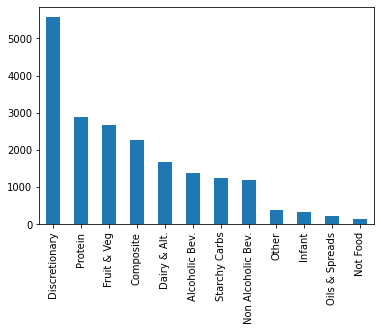

In [50]:
new_df['Eatwell_Segment'].value_counts().plot(kind='bar')

In [65]:
list(new_df)

['Unnamed: 0',
 'Retailer Product Name',
 'Retailer Barcode',
 'Retailer Identifier Additional',
 'Retailer Shelf',
 'Shelf_1',
 'Shelf_2',
 'Shelf_3',
 'Shelf_4',
 'Shelf_5',
 'Dried Fruit, Veg and Nut %',
 'Non Dried Fruit, Veg and Nut %',
 'Calc Fruit, Veg and Nut %',
 'Energy Points',
 'Fibre Points',
 'Saturated Fat Points',
 'Sugar Points',
 'Sodium Points',
 'Protein Points',
 'Fruit, Veg and Nuts Points',
 'A points',
 'C points',
 'HFSS Numeric Score',
 'HFSS Score_x',
 'HFSS Status',
 'HFSS Ingredients - All All',
 'HFSS Ingredients - All Name',
 'HFSS Ingredients - All Value',
 'HFSS Ingredients - Non Dried All',
 'HFSS Ingredients - Non Dried Name',
 'HFSS Ingredients - Non Dried Value',
 'HFSS Ingredients - Dried All',
 'HFSS Ingredients - Dried Name',
 'HFSS Ingredients - Dried Value',
 'Product Type',
 'Last Seen Date',
 'Carbohydrate_g',
 'Energy_kj',
 'Fat_g',
 'Fibre_g',
 'Protein_g',
 'Salt_g',
 'Saturates_g',
 'Sugars_g',
 'Sodium_mg',
 'Density',
 'Retailer Unit',


In [71]:
# use interactive histograms to identify outliers
fig = px.histogram(new_df.fillna(''), x='kcal/100g', y='Protein/100g', color="Eatwell_Segment", marginal="rug",
                   hover_data=['Product Name','Retailer Product Name']) #hover_data selects the variable which appears when hovering over the data points
fig.show()

In [72]:
# use interactive histograms to identify outliers
fig = px.histogram(new_df.fillna(''), x='kcal/100g', y='Sugar/100g', color="Eatwell_Segment", marginal="rug",
                   hover_data=['Product Name','Retailer Product Name']) #hover_data selects the variable which appears when hovering over the data points
fig.show()